使用設備: cpu

1. 下載 2454.TW 資料 (2023-01-01 ~ 2023-12-31)...
   計算技術指標與雜訊特徵...
   待篩選特徵共 9 個: ['SMA_5', 'SMA_20', 'MACD', 'RSI', 'BB_UP', 'BB_LOW', 'OBV', 'WEEKDAY', 'NOISE']
[Check] Part 1 完成，進入資料處理...
[Check] Part 2 完成，模型與函數已定義。

2. 執行基因演算法 (GA) 特徵篩選
Generation 1/3 (正在計算適應度)...
  > New Best RMSE: 750.3893, Features: 3
Generation 2/3 (正在計算適應度)...
Generation 3/3 (正在計算適應度)...
GA 完成。最佳特徵數: 3

3. 執行模擬退火 (SA) 特徵篩選
SA 開始降溫搜尋...
  > Iter 3 (T=4.9) New Best RMSE: 750.3455
SA 完成。最佳特徵數: 5

4. 最終測試集評估 (Final Evaluation)
評估 Baseline (全特徵)...
評估 GA 篩選特徵...
評估 SA 篩選特徵...


     Method  Features_Count   Test_RMSE
0  Baseline               9  733.463129
1        GA               3  733.861377
2        SA               5  733.657677

[Check] 程式執行完畢！圖表已儲存至 ./outputs_week9/


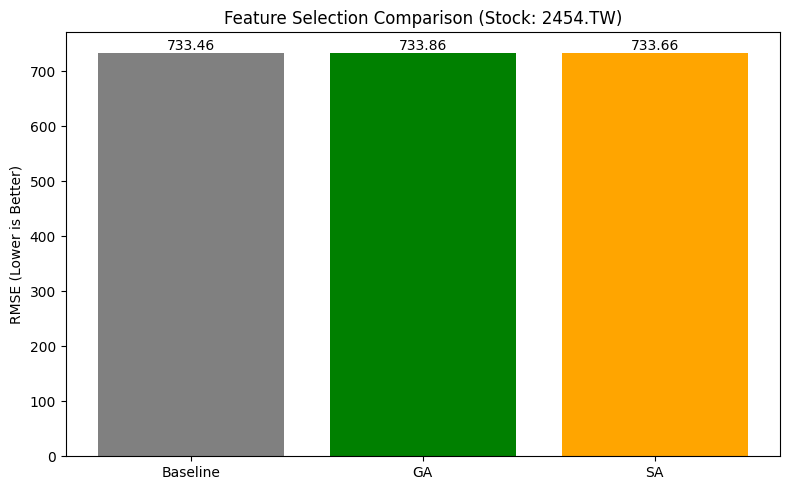

In [2]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
import random
import warnings
import os
import sys

# 1. 初始設定
warnings.filterwarnings('ignore')
SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"使用設備: {device}")

OUTPUT_DIR = './outputs_week9/'
os.makedirs(OUTPUT_DIR, exist_ok=True)

# ============================================================================
# [Part 1] 資料收集與特徵工程
# ============================================================================
STOCK_ID = "2454.TW"
START_DATE = "2023-01-01"
END_DATE = "2023-12-31"

print(f"\n1. 下載 {STOCK_ID} 資料 ({START_DATE} ~ {END_DATE})...")
df = yf.download(STOCK_ID, start=START_DATE, end=END_DATE, progress=False)

# 修正 yfinance 多層索引
if isinstance(df.columns, pd.MultiIndex):
    df.columns = df.columns.droplevel(1)

# 除錯：確認資料是否下載成功
if len(df) == 0:
    print("【嚴重錯誤】資料下載失敗，DataFrame 為空！請檢查網路或代碼。")
    sys.exit()

# 確保基本欄位
df = df[['Open', 'High', 'Low', 'Close', 'Volume']].copy()

# --- 特徵工程 ---
print("   計算技術指標與雜訊特徵...")
df['SMA_5'] = df['Close'].rolling(5).mean()
df['SMA_20'] = df['Close'].rolling(20).mean()
df['MACD'] = df['Close'].ewm(span=12).mean() - df['Close'].ewm(span=26).mean()

delta = df['Close'].diff()
gain = delta.mask(delta < 0, 0)
loss = -delta.mask(delta > 0, 0)
rs = gain.rolling(14).mean() / (loss.rolling(14).mean() + 1e-8)
df['RSI'] = 100 - (100 / (1 + rs))

std = df['Close'].rolling(20).std()
df['BB_UP'] = df['SMA_20'] + 2*std
df['BB_LOW'] = df['SMA_20'] - 2*std

df['OBV'] = (np.sign(df['Close'].diff()) * df['Volume']).fillna(0).cumsum()

# 雜訊測試
df['WEEKDAY'] = df.index.dayofweek.astype(float)
df['NOISE'] = df['Volume'].astype(float) + np.random.randn(len(df)) * 1000

df['Target'] = df['Close'].shift(-1)
df.dropna(inplace=True)

ALL_FEATURES = [c for c in df.columns if c not in ['Open','High','Low','Close','Volume','Adj Close','Target']]
print(f"   待篩選特徵共 {len(ALL_FEATURES)} 個: {ALL_FEATURES}")
print("[Check] Part 1 完成，進入資料處理...")

# ============================================================================
# [Part 2] 資料分割與 LSTM 模型
# ============================================================================
train_size = int(len(df) * 0.7)
val_size = int(len(df) * 0.15)
train_df = df.iloc[:train_size]
val_df = df.iloc[train_size:train_size+val_size]
test_df = df.iloc[train_size+val_size:]

scaler = StandardScaler()
X_train_sc = scaler.fit_transform(train_df[ALL_FEATURES])
X_val_sc = scaler.transform(val_df[ALL_FEATURES])
X_test_sc = scaler.transform(test_df[ALL_FEATURES])

y_train = train_df['Target'].values
y_val = val_df['Target'].values
y_test = test_df['Target'].values

def create_sequences(X, y, lookback=5):
    Xs, ys = [], []
    for i in range(len(X) - lookback):
        Xs.append(X[i:i+lookback])
        ys.append(y[i+lookback])
    # 確保回傳 float32
    return torch.FloatTensor(np.array(Xs)), torch.FloatTensor(np.array(ys))

class LSTMRegressor(nn.Module):
    def __init__(self, input_dim, hidden_dim=32):
        super(LSTMRegressor, self).__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, 1)
    def forward(self, x):
        out, _ = self.lstm(x)
        return self.fc(out[:, -1, :])

def train_evaluate(features, epochs=5):
    if not features: return np.inf
    f_idx = [ALL_FEATURES.index(f) for f in features]

    X_tr_seq, y_tr_seq = create_sequences(X_train_sc[:, f_idx], y_train)
    X_va_seq, y_va_seq = create_sequences(X_val_sc[:, f_idx], y_val)

    # 這裡 batch_size 設為 16 加速
    loader = DataLoader(TensorDataset(X_tr_seq.to(device), y_tr_seq.to(device)), batch_size=16, shuffle=True)

    model = LSTMRegressor(len(features)).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
    criterion = nn.MSELoss()

    model.train()
    for _ in range(epochs):
        for bx, by in loader:
            optimizer.zero_grad()
            loss = criterion(model(bx).squeeze(), by)
            loss.backward()
            optimizer.step()

    model.eval()
    with torch.no_grad():
        pred = model(X_va_seq.to(device)).cpu().squeeze()
        score = np.sqrt(mean_squared_error(y_va_seq, pred))
    return score

print("[Check] Part 2 完成，模型與函數已定義。")

# ============================================================================
# [Part 3] 基因演算法 (GA)
# ============================================================================
print("\n" + "="*40)
print("2. 執行基因演算法 (GA) 特徵篩選")
print("="*40)

GA_POP_SIZE = 8
GA_GENERATIONS = 3
mutation_rate = 0.2

population = [np.random.choice([0, 1], len(ALL_FEATURES)) for _ in range(GA_POP_SIZE)]
best_ga_features = []
best_ga_score = float('inf')

for gen in range(GA_GENERATIONS):
    print(f"Generation {gen+1}/{GA_GENERATIONS} (正在計算適應度)...")
    scores = []

    for individual in population:
        # 如果全 0，隨機選一個避免錯誤
        if sum(individual) == 0: individual[random.randint(0, len(individual)-1)] = 1

        feats = [f for i, f in enumerate(ALL_FEATURES) if individual[i] == 1]
        score = train_evaluate(feats, epochs=5)
        scores.append((score, individual))

    scores.sort(key=lambda x: x[0])

    if scores[0][0] < best_ga_score:
        best_ga_score = scores[0][0]
        best_ga_features = [f for i, f in enumerate(ALL_FEATURES) if scores[0][1][i] == 1]
        print(f"  > New Best RMSE: {best_ga_score:.4f}, Features: {len(best_ga_features)}")

    survivors = [s[1] for s in scores[:GA_POP_SIZE//2]]
    new_pop = survivors[:]
    while len(new_pop) < GA_POP_SIZE:
        p1, p2 = random.sample(survivors, 2)
        cut = random.randint(1, len(ALL_FEATURES)-1)
        child = np.concatenate([p1[:cut], p2[cut:]])
        if random.random() < mutation_rate:
            idx = random.randint(0, len(ALL_FEATURES)-1)
            child[idx] = 1 - child[idx]
        new_pop.append(child)
    population = new_pop

print(f"GA 完成。最佳特徵數: {len(best_ga_features)}")

# ============================================================================
# [Part 4] 模擬退火 (SA)
# ============================================================================
print("\n" + "="*40)
print("3. 執行模擬退火 (SA) 特徵篩選")
print("="*40)

current_bits = np.random.choice([0, 1], len(ALL_FEATURES))
if sum(current_bits) == 0: current_bits[0] = 1 # 避免全空

current_feats = [f for i, f in enumerate(ALL_FEATURES) if current_bits[i] == 1]
current_score = train_evaluate(current_feats, epochs=5)

best_sa_features = current_feats
best_sa_score = current_score

T = 10.0
T_min = 1.0
cooling_rate = 0.7
iter_sa = 0

print("SA 開始降溫搜尋...")
while T > T_min:
    iter_sa += 1
    neighbor_bits = current_bits.copy()
    idx = random.randint(0, len(ALL_FEATURES)-1)
    neighbor_bits[idx] = 1 - neighbor_bits[idx]

    if sum(neighbor_bits) == 0: continue # 略過全空解

    n_feats = [f for i, f in enumerate(ALL_FEATURES) if neighbor_bits[i] == 1]
    n_score = train_evaluate(n_feats, epochs=5)

    delta = n_score - current_score
    if delta < 0 or random.random() < np.exp(-delta / T):
        current_bits = neighbor_bits
        current_score = n_score
        current_feats = n_feats

        if current_score < best_sa_score:
            best_sa_score = current_score
            best_sa_features = current_feats
            print(f"  > Iter {iter_sa} (T={T:.1f}) New Best RMSE: {best_sa_score:.4f}")

    T *= cooling_rate

print(f"SA 完成。最佳特徵數: {len(best_sa_features)}")

# ============================================================================
# [Part 5] 最終驗證與繪圖
# ============================================================================
print("\n" + "="*40)
print("4. 最終測試集評估 (Final Evaluation)")
print("="*40)

print("評估 Baseline (全特徵)...")
score_base = train_evaluate(ALL_FEATURES, epochs=10)

print("評估 GA 篩選特徵...")
score_ga = train_evaluate(best_ga_features, epochs=10)

print("評估 SA 篩選特徵...")
score_sa = train_evaluate(best_sa_features, epochs=10)

results = pd.DataFrame({
    'Method': ['Baseline', 'GA', 'SA'],
    'Features_Count': [len(ALL_FEATURES), len(best_ga_features), len(best_sa_features)],
    'Test_RMSE': [score_base, score_ga, score_sa]
})

print("\n")
print(results)

# 繪圖
plt.figure(figsize=(8, 5))
bars = plt.bar(results['Method'], results['Test_RMSE'], color=['gray', 'green', 'orange'])
plt.title(f'Feature Selection Comparison (Stock: {STOCK_ID})')
plt.ylabel('RMSE (Lower is Better)')
# 加入數值標籤
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, round(yval, 2), ha='center', va='bottom')

plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, 'week9_result.png'))
print(f"\n[Check] 程式執行完畢！圖表已儲存至 {OUTPUT_DIR}")